In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage import segmentation

(417, 500) 237 12
(417, 500) int64 [0 1]


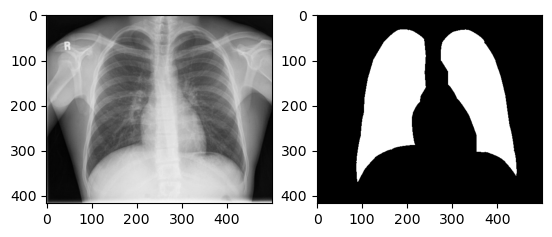

In [2]:
# read grayscale image and its mask
# img = io.imread("./openist/1-10-500-500-100.jpg", as_gray=False)
img = io.imread("./openist/1-10-500-500-100.jpg", as_gray=True)
print(img.shape, img.max(), img.min())

# read its mask
mask = io.imread("./openist/1-10-500-500-100@.png").astype(np.int64)
mask[mask != 0] = 1
print(mask.shape, mask.dtype, np.unique(mask))

fig, [ax1, ax2] = plt.subplots(1, 2)
ax1.imshow(img, cmap='gray')
ax2.imshow(mask, cmap='gray')

(315, 275, 3) 255 11
(315, 275) int64 [0 1]


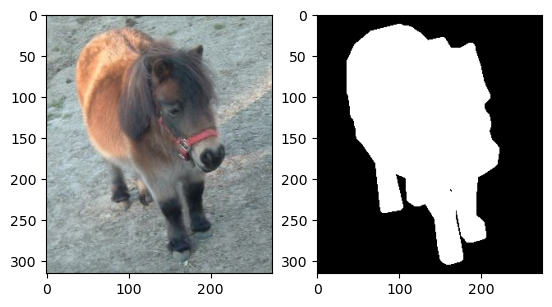

In [3]:
# read colorful image
img = io.imread("../Data/VOC2012/JPEGImages/2007_001724.jpg", as_gray=False)
print(img.shape, img.max(), img.min())

# read its mask
mask = io.imread("../Data/VOC2012/SegmentationObject/2007_001724.png").astype(np.int64)
mask = mask[:, :, 0]
mask[mask != 0] = 1
print(mask.shape, mask.dtype, np.unique(mask))

_, [ax1, ax2] = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(mask, cmap='gray')

In [4]:
# torch_channels: update image dimension
if len(img.shape) == 2:
    img = np.expand_dims(img, axis=0)
else:
    img = np.moveaxis(img, -1, 0)
print(img.shape, img.max(), img.min())

(3, 315, 275) 255 11


In [5]:
# norm (old): normalized image with zero mean and unit std
if len(img.shape) == 2:
    img = (img - img.mean()) / img.std()
else:
    for b in range(img.shape[2]):
        img[:,:,b] = (img[:,:,b] - img[:,:,b].mean()) / img[:,:,b].std()
print(img.shape, img.max(), img.min())

# updated norm for multi-channel image
normalized = np.zeros(img.shape)
for b in range(img.shape[2]):
    normalized[:,:,b] = (img[:,:,b] - img[:,:,b].mean()) / img[:,:,b].std()
print(normalized.shape, normalized.max(), normalized.min())
for b in range(normalized.shape[2]):
    normalized_comp = normalized[:,:,b]
    print(normalized_comp.mean(), normalized_comp.std(), end=" | ")

(3, 315, 275) 255 0
(3, 315, 275) 3.1544441491470705 -0.5562974149894511
4.5113824492704774e-17 1.0 | 7.518970748784129e-17 1.0 | 0.0 1.0 | 4.5113824492704774e-17 1.0 | -4.5113824492704774e-17 1.0 | -3.007588299513652e-17 1.0 | -3.007588299513652e-17 0.9999999999999998 | -6.015176599027304e-17 0.9999999999999998 | 7.518970748784129e-17 0.9999999999999999 | -3.007588299513652e-17 1.0 | 5.2632795241488905e-17 0.9999999999999999 | 3.007588299513652e-17 1.0 | 3.007588299513652e-17 0.9999999999999999 | -3.007588299513652e-17 1.0 | 7.51897074878413e-18 0.9999999999999999 | -7.51897074878413e-18 1.0 | -6.015176599027304e-17 0.9999999999999999 | -1.0526559048297781e-16 0.9999999999999998 | -7.518970748784129e-17 1.0 | -9.022764898540955e-17 1.0 | 3.007588299513652e-17 1.0 | -7.518970748784129e-17 1.0 | 0.0 1.0 | 3.007588299513652e-17 1.0 | -1.503794149756826e-17 1.0000000000000002 | 1.503794149756826e-17 1.0 | 3.007588299513652e-17 0.9999999999999999 | -1.0526559048297781e-16 1.0 | 0.0 1.0 | 4

In [6]:
def sparse_region(img, msk, sparsity='random', index=-1):
    # Compactness of SLIC for each dataset.
    cpn = {
        # MEDICAL
        'nih_labeled': 0.6,
        'inbreast': 0.6,
        'shenzhen': 0.7,
        'montgomery': 0.5,
        'openist': 0.5,
        'jsrt': 0.5,
        'ufba': 0.5,
        'lidc_idri_drr': 0.5,
        'panoramic': 0.75,
        'mias': 0.45
    }

    # Copying mask and starting it with -1 for inserting sparsity.
    new_msk = np.zeros_like(msk)
    new_msk[:] = -1

    # Computing SLIC super pixels.
    slic = segmentation.slic(
        img, n_segments=250, compactness=cpn['openist'], start_label=1)
    labels = np.unique(slic)

    # Finding 'pure' regions, that is, the ones that only contain one label within.
    pos_sp = []
    neg_sp = []

    for l in labels:
        sp = msk[slic == l].ravel()
        cnt = np.bincount(sp)

        if len(cnt) == 1:
            neg_sp.append(l)
        else:
            if cnt[0] == 0:
                pos_sp.append(l)

    neg_sp = np.array(neg_sp)
    pos_sp = np.array(pos_sp)

    if sparsity == 'random':

        # Randomly choosing sparsity (number of slic regions -- [0..1]).
        sparsity = np.random.random()

        # Random permutation to negative regions.
        perm_neg = np.random.permutation(len(neg_sp))

        # Random permutation to positive regions.
        perm_pos = np.random.permutation(len(pos_sp))

    elif isinstance(sparsity, float) and sparsity > 0:

        # Fixing seed.
        np.random.seed(index)
        # Predefined permutation to negative regions (fixed by seed).
        perm_neg = np.random.permutation(len(neg_sp))

        # Fixing seed.
        np.random.seed(index)
        # Predefined permutation to positive regions (fixed by seed).
        perm_pos = np.random.permutation(len(pos_sp))

    # Only keeping the selected k regions.
    for sp in neg_sp[perm_neg[:max(1, round(sparsity * len(perm_neg)))]]:
        new_msk[slic == sp] = 0
    for sp in pos_sp[perm_pos[:max(1, round(sparsity * len(perm_pos)))]]:
        new_msk[slic == sp] = 1

    return new_msk, (slic, neg_sp, pos_sp, neg_sp[perm_neg[:max(1, round(sparsity * len(perm_neg)))]], pos_sp[perm_pos[:max(1, round(sparsity * len(perm_pos)))]])

(315, 275) 1 -1 [-1  1]
(315, 275) 37 1 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]


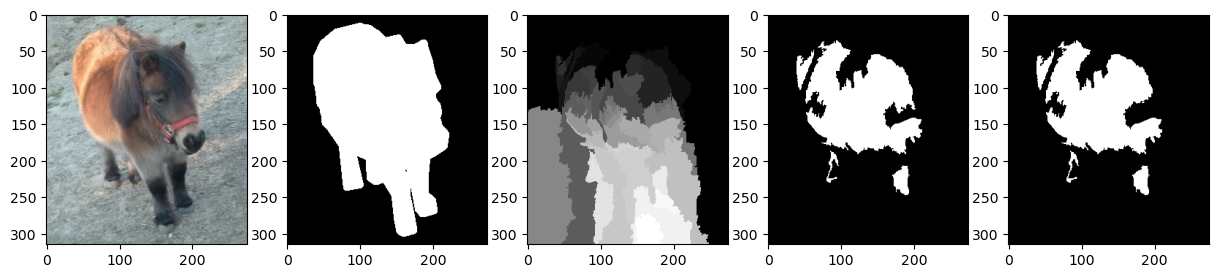

In [121]:
new_mask, (slic, neg_sp, pos_sp, neg_sp_filt, pos_sp_filt) = sparse_region(img, mask)
print(new_mask.shape, new_mask.max(), new_mask.min(), np.unique(new_mask))
print(slic.shape, slic.max(), slic.min(), np.unique(slic))

full_mask = np.zeros(slic.shape) - 1
for sp in neg_sp:
    full_mask[slic == sp] = 0
for sp in pos_sp:
    full_mask[slic == sp] = 1

fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(15,5))
ax1.imshow(img)
ax2.imshow(mask, cmap='gray')
ax3.imshow(slic, cmap='gray')
ax4.imshow(full_mask, cmap='gray')
ax5.imshow(new_mask, cmap='gray')